# Data Loading and Preprocessing

In [ ]:

import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the datasets
true_news = pd.read_csv('True.csv', encoding='utf-8', engine='python')
fake_news = pd.read_csv('Fake.csv', encoding='utf-8', engine='python')

# Label the datasets: 1 for true news, 0 for fake news
true_news['label'] = 1
fake_news['label'] = 0

# Combine the datasets
data = pd.concat([true_news, fake_news], axis=0).reset_index(drop=True)

# Shuffle the combined dataset to ensure random distribution
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Define text cleaning function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords and lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Combine title and text into a single content field and clean it
data['content'] = data['title'] + ' ' + data['text']
data['cleaned_content'] = data['content'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## TF-IDF and Baseline Model Training

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'C': 100, 'solver': 'liblinear'}
Best cross-validation accuracy: 0.9945152956420552
Test Accuracy: 0.9956570155902005
Test Precision: 0.9951321279554938
Test Recall: 0.9958246346555324
Test F1 Score: 0.9954782608695653


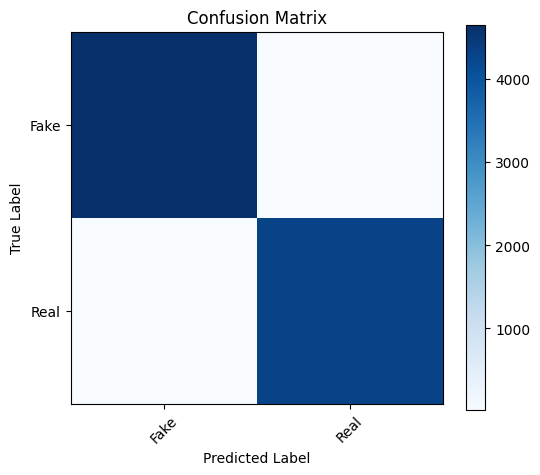

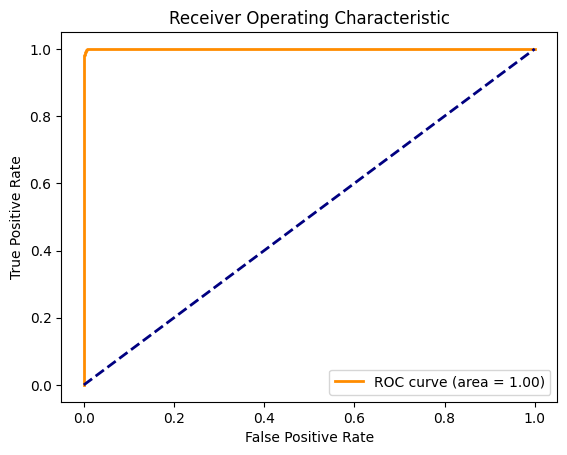

In [ ]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(data[['cleaned_content', 'label']], test_size=0.2, random_state=42)

# Feature extraction using TF-IDF (on cleaned text)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(train_df['cleaned_content'])
X_test = tfidf_vectorizer.transform(test_df['cleaned_content'])
y_train = train_df['label'].values
y_test = test_df['label'].values

# Baseline Model: Logistic Regression with Hyperparameter Tuning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

logreg = LogisticRegression(random_state=42, max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Test Accuracy:", acc)
print("Test Precision:", prec)
print("Test Recall:", rec)
print("Test F1 Score:", f1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake', 'Real'], rotation=45)
plt.yticks(tick_marks, ['Fake', 'Real'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Save the best model to disk
import pickle
with open('best_logreg_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)


# Advanced Model Training - Bert

In [ ]:
# Advanced Model Development: BERT Fine-Tuning

!pip install transformers datasets evaluate
import torch
from transformers import BertTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import evaluate
import os

# Disable W&B (Weights & Biases) logging for this run
os.environ['WANDB_MODE'] = 'disabled'

# Prepare train and test data for Hugging Face Datasets
train_df = train_df.rename(columns={'cleaned_content': 'text'})
test_df = test_df.rename(columns={'cleaned_content': 'text'})
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenization function for dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

# Tokenize the dataset
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Convert datasets to PyTorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Define evaluation metrics
metric_accuracy = evaluate.load('accuracy')
metric_precision = evaluate.load('precision')
metric_recall = evaluate.load('recall')
metric_f1 = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)
    precision = metric_precision.compute(predictions=predictions, references=labels, average='weighted')
    recall = metric_recall.compute(predictions=predictions, references=labels, average='weighted')
    f1 = metric_f1.compute(predictions=predictions, references=labels, average='weighted')
    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision['precision'],
        'recall': recall['recall'],
        'f1': f1['f1']
    }

# Set up training arguments
training_args = TrainingArguments(
    output_dir='results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[],  # disable default logging to W&B
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='logs',
    logging_steps=10,
    metric_for_best_model='accuracy',
    bf16=True
)




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.1 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/8980 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
# Train the model
trainer.train()

# Evaluate the model on the test set
results = trainer.evaluate()
print("Evaluation results:", results)

# Save the fine-tuned model and tokenizer
model.save_pretrained('fine_tuned_bert')
tokenizer.save_pretrained('fine_tuned_bert')


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000200,0.002805,0.999555,0.999555,0.999555,0.999555
2,0.000000,0.000722,0.999889,0.999889,0.999889,0.999889


Evaluation results: {'eval_loss': 0.0007223196444101632, 'eval_accuracy': 0.9998886414253898, 'eval_precision': 0.9998886652709089, 'eval_recall': 0.9998886414253898, 'eval_f1': 0.9998886409288429, 'eval_runtime': 7.6223, 'eval_samples_per_second': 1178.116, 'eval_steps_per_second': 73.731, 'epoch': 2.0}


('fine_tuned_bert/tokenizer_config.json',
 'fine_tuned_bert/special_tokens_map.json',
 'fine_tuned_bert/vocab.txt',
 'fine_tuned_bert/added_tokens.json')